In [1]:
import torch.optim as optim
import torch.nn.functional as F
import nltk
import random
import numpy as np
from collections import Counter, OrderedDict
import nltk
from copy import deepcopy
import os
import re
import unicodedata
from torch.nn.utils.rnn import PackedSequence, pack_padded_sequence
random.seed(1024)

/opt/sw/spack/apps/linux-rhel8-x86_64_v2/gcc-10.3.0/python-3.9.9-jh/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
import torch
import random
from torch.autograd import Variable

USE_CUDA = torch.cuda.is_available()
gpus = [0]
torch.cuda.set_device(gpus[0])

FloatTensor = torch.cuda.FloatTensor if USE_CUDA else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if USE_CUDA else torch.LongTensor
ByteTensor = torch.cuda.ByteTensor if USE_CUDA else torch.ByteTensor

def flatten(nested_list):
    return [item for sublist in nested_list for item in sublist]

def generate_batches(batch_size, training_data):
    random.shuffle(training_data)
    start_index = 0
    end_index = batch_size
    while end_index < len(training_data):
        batch = training_data[start_index:end_index]
        temp = end_index
        end_index += batch_size
        start_index = temp
        yield batch

    if end_index >= len(training_data):
        batch = training_data[start_index:]
        yield batch

def pad_batch(batch, word_to_index):
    facts, questions, answers = zip(*batch)
    max_fact_count = max(len(f) for f in facts)
    max_fact_length = max(f.size(1) for f in flatten(facts))
    max_question_length = max(q.size(1) for q in questions)
    max_answer_length = max(a.size(1) for a in answers)

    padded_facts, fact_masks, padded_questions, padded_answers = [], [], [], []
    for i in range(len(batch)):
        padded_fact = []
        for fact in facts[i]:
            if fact.size(1) < max_fact_length:
                padded_fact.append(torch.cat([fact, Variable(LongTensor([word_to_index['<PAD>']] * (max_fact_length - fact.size(1)))).view(1, -1)], 1))
            else:
                padded_fact.append(fact)

        while len(padded_fact) < max_fact_count:
            padded_fact.append(Variable(LongTensor([word_to_index['<PAD>']] * max_fact_length)).view(1, -1))

        padded_fact = torch.cat(padded_fact)
        padded_facts.append(padded_fact)
        fact_masks.append(torch.cat([Variable(ByteTensor(tuple(map(lambda s: s == 0, t.data))), volatile=False) for t in padded_fact]).view(padded_fact.size(0), -1))

        if questions[i].size(1) < max_question_length:
            padded_questions.append(torch.cat([questions[i], Variable(LongTensor([word_to_index['<PAD>']] * (max_question_length - questions[i].size(1)))).view(1, -1)], 1))
        else:
            padded_questions.append(questions[i])

        if answers[i].size(1) < max_answer_length:
            padded_answers.append(torch.cat([answers[i], Variable(LongTensor([word_to_index['<PAD>']] * (max_answer_length - answers[i].size(1)))).view(1, -1)], 1))
        else:
            padded_answers.append(answers[i])

    questions_tensor = torch.cat(padded_questions)
    answers_tensor = torch.cat(padded_answers)
    question_masks = torch.cat([Variable(ByteTensor(tuple(map(lambda s: s == 0, t.data))), volatile=False) for t in questions_tensor]).view(questions_tensor.size(0), -1)
    
    return padded_facts, fact_masks, questions_tensor, question_masks, answers_tensor



In [3]:
import torch
from torch.autograd import Variable
from copy import deepcopy

def sequence_to_tensor(sequence, word_to_index_map):
    index_list = [word_to_index_map.get(word, word_to_index_map["<UNK>"]) for word in sequence]
    return Variable(LongTensor(index_list))

data_file_path = 'data/en-10k/qa17_positional-reasoning_train.txt'
raw_data = open(data_file_path).readlines()
processed_data = [line.strip() for line in raw_data]

training_examples = []
current_facts = []
for line in processed_data:
    line_index = line.split(' ')[0]
    if line_index == '1':
        current_facts = []

    if '?' in line:
        question_and_answer = line.split('\t')
        question = question_and_answer[0].strip().replace('?', '').split(' ')[1:] + ['?']
        answer = question_and_answer[1].split() + ['</s>']
        copied_facts = deepcopy(current_facts)
        training_examples.append([copied_facts, question, answer])
    else:
        fact = line.replace('.', '').split(' ')[1:] + ['</s>']
        current_facts.append(fact)

facts, questions, answers = zip(*training_examples)
vocabulary = set(flatten(flatten(facts)) + flatten(questions) + flatten(answers))
word_to_index_map = {'<PAD>': 0, '<UNK>': 1, '<s>': 2, '</s>': 3}
for vocab_word in vocabulary:
    if vocab_word not in word_to_index_map:
        word_to_index_map[vocab_word] = len(word_to_index_map)

index_to_word_map = {index: word for word, index in word_to_index_map.items()}

for sample in training_examples:
    for i, fact in enumerate(sample[0]):
        sample[0][i] = sequence_to_tensor(fact, word_to_index_map).view(1, -1)
    sample[1] = sequence_to_tensor(sample[1], word_to_index_map).view(1, -1)
    sample[2] = sequence_to_tensor(sample[2], word_to_index_map).view(1, -1)



In [4]:
import torch.nn as nn
class DMN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout_p=0.1):
        super(DMN, self).__init__()
        
        self.hidden_size=hidden_size
        
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.fact_gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.ques_gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.attn_weights = nn.Sequential(nn.Linear(4*hidden_size, hidden_size), nn.Tanh(), nn.Linear(hidden_size, 1), nn.Softmax())
        
        self.epsisodic_grucell = nn.GRUCell(hidden_size, hidden_size)
        self.memory_grucell = nn.GRUCell(hidden_size, hidden_size)
        self.ans_grucell = nn.GRUCell(2*hidden_size, hidden_size)
        
        self.ans_fc = nn.Linear(hidden_size, output_size)
        
        self.dropout = nn.Dropout(dropout_p)
    
    def init_hidden(self, inputs):
        hidden = Variable(torch.zeros(1, inputs.size(0), self.hidden_size))
        return hidden.cuda() if USE_CUDA else hidden
    
    def init_weight(self):
        nn.init.xavier_uniform_(self.embedding.state_dict()['weight'])

        for name, param in self.fact_gru.state_dict().items():
            if 'weight' in name: nn.init.xavier_normal_(param)
        for name, param in self.ques_gru.state_dict().items():
            if 'weight' in name: nn.init.xavier_normal_(param)
        for name, param in self.attn_weights.state_dict().items():
            if 'weight' in name: nn.init.xavier_normal_(param)
        for name, param in self.epsisodic_grucell.state_dict().items():
            if 'weight' in name: nn.init.xavier_normal_(param)
        for name, param in self.memory_grucell.state_dict().items():
            if 'weight' in name: nn.init.xavier_normal_(param)
        for name, param in self.ans_grucell.state_dict().items():
            if 'weight' in name: nn.init.xavier_normal_(param)

        nn.init.xavier_normal_(self.ans_fc.state_dict()['weight'])
        self.ans_fc.bias.data.fill_(0)
        
    def forward(self, facts, facts_masks, question, question_masks, num_decode, episodes=3, is_training=True):
        #input module
        concated=[]
        for fact, fact_mask in zip(facts, facts_masks):
            embedded = self.embedding(fact)
            if(is_training):
                embedded = self.dropout(embedded)
            hidden = self.init_hidden(fact)
            output, hidden = self.fact_gru(embedded, hidden)
            hidden_real = []
            for i, o in enumerate(output):
                length = fact_mask[i].data.tolist().count(0)
                hidden_real.append(o[length-1])
            concated.append(torch.cat(hidden_real).view(fact.size(0), -1).unsqueeze(0)) 
        encoded_facts = torch.cat(concated)
        #question module
        hidden=self.init_hidden(question)
       
        embedded = self.embedding(question)
        if(is_training):
                embedded = self.dropout(embedded)
        output, hidden = self.ques_gru(embedded, hidden)

        if is_training == True:
            real_question = []
            for i, o in enumerate(output): # B,T,D
                real_length = question_masks[i].data.tolist().count(0)

                real_question.append(o[real_length - 1])

            encoded_question = torch.cat(real_question).view(questions.size(0), -1) # B,D
        else: # for inference mode
            encoded_question = hidden.squeeze(0) # B,D
            
        #episodic memory module
        
        memory = encoded_question
        T_C = encoded_facts.size(1)
        B = encoded_facts.size(0)
        for i in range(episodes):
            hidden = self.init_hidden(encoded_facts.transpose(0, 1)[0]).squeeze(0) # B,D
            for t in range(T_C):
               
                z = torch.cat([
                                    encoded_facts.transpose(0, 1)[t] * encoded_question, # B,D , element-wise product
                                    encoded_facts.transpose(0, 1)[t] * memory, # B,D , element-wise product
                                    torch.abs(encoded_facts.transpose(0,1)[t] - encoded_question), # B,D
                                    torch.abs(encoded_facts.transpose(0,1)[t] - memory) # B,D
                                ], 1)
                g_t = self.attn_weights(z) # B,1 scalar
                hidden = g_t * self.epsisodic_grucell(encoded_facts.transpose(0, 1)[t], hidden) + (1 - g_t) * hidden
                
            e = hidden
            memory = self.memory_grucell(e, memory)
        
        # Answer Module
        answer_hidden = memory
        start_decode = Variable(LongTensor([[word_to_index_map['<s>']] * memory.size(0)])).transpose(0, 1)
        y_t_1 = self.embedding(start_decode).squeeze(1) # B,D
        
        decodes = []
        for t in range(num_decode):
            answer_hidden = self.ans_grucell(torch.cat([y_t_1, encoded_question], 1), answer_hidden)
            decodes.append(F.log_softmax(self.ans_fc(answer_hidden),1))
        return torch.cat(decodes, 1).view(B * num_decode, -1)

In [5]:
HIDDEN_SIZE = 50
BATCH_SIZE = 64
LR = 0.001
EPOCH = 50
NUM_EPISODE = 3
EARLY_STOPPING = False
EMBEDDING_DIM =50

In [6]:
model = DMN(len(word_to_index_map), HIDDEN_SIZE, len(word_to_index_map))
model.init_weight()
if USE_CUDA:
    model = model.cuda()

loss_function = nn.CrossEntropyLoss(ignore_index=0)
optimizer = optim.Adam(model.parameters(), lr=LR)

In [7]:
losses1=[]
for epoch in range(EPOCH):
    losses = []
    if EARLY_STOPPING: 
        break
        
    for i,batch in enumerate(generate_batches(BATCH_SIZE, training_examples)):
        facts, fact_masks, questions, question_masks, answers = pad_batch(batch, word_to_index_map)
        
        model.zero_grad()
        pred = model(facts, fact_masks, questions, question_masks, answers.size(1), NUM_EPISODE, True)
        loss = loss_function(pred, answers.view(-1))
        losses.append(loss.item())
        
        loss.backward()
        optimizer.step()
        
        if i % 100 == 0:
            print("[%d/%d] mean_loss : %0.2f" %(epoch, EPOCH, np.mean(losses)))
            
            if np.mean(losses) < 0.01:
                EARLY_STOPPING = True
                print("Early Stopping!")
                break
            losses = []
    losses1.append(np.mean(losses))

/opt/sw/spack/apps/linux-rhel8-x86_64_v2/gcc-10.3.0/python-3.9.9-jh/lib/python3.9/site-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


[0/50] mean_loss : 3.20
[0/50] mean_loss : 0.86
[1/50] mean_loss : 0.35
[1/50] mean_loss : 0.35
[2/50] mean_loss : 0.35
[2/50] mean_loss : 0.35
[3/50] mean_loss : 0.35
[3/50] mean_loss : 0.35
[4/50] mean_loss : 0.35
[4/50] mean_loss : 0.35
[5/50] mean_loss : 0.34
[5/50] mean_loss : 0.35
[6/50] mean_loss : 0.35
[6/50] mean_loss : 0.35
[7/50] mean_loss : 0.35
[7/50] mean_loss : 0.35
[8/50] mean_loss : 0.35
[8/50] mean_loss : 0.35
[9/50] mean_loss : 0.34
[9/50] mean_loss : 0.35
[10/50] mean_loss : 0.35
[10/50] mean_loss : 0.35
[11/50] mean_loss : 0.35
[11/50] mean_loss : 0.35
[12/50] mean_loss : 0.35
[12/50] mean_loss : 0.35
[13/50] mean_loss : 0.35
[13/50] mean_loss : 0.35
[14/50] mean_loss : 0.34
[14/50] mean_loss : 0.35
[15/50] mean_loss : 0.35
[15/50] mean_loss : 0.35
[16/50] mean_loss : 0.35
[16/50] mean_loss : 0.35
[17/50] mean_loss : 0.35
[17/50] mean_loss : 0.35
[18/50] mean_loss : 0.34
[18/50] mean_loss : 0.35
[19/50] mean_loss : 0.35
[19/50] mean_loss : 0.35
[20/50] mean_loss : 

In [8]:
print(len(losses1))
print(losses1)

50
[0.3618998447699206, 0.3515688691820417, 0.34927765652537346, 0.34830011054873466, 0.34925996884703636, 0.34776782404099194, 0.3480599213923727, 0.34823588973709513, 0.3476379561637129, 0.34734330805284636, 0.34749370547277586, 0.3476337944822652, 0.34747676870652605, 0.3475588650575706, 0.3473850642996175, 0.347673128758158, 0.34760779195598196, 0.3470092373234885, 0.34738509729504585, 0.3470698211874281, 0.3471668948020254, 0.34717084041663576, 0.34761867246457506, 0.34732159812535557, 0.3467982267694814, 0.34719036679182735, 0.3475447419498648, 0.34732286791716305, 0.3473794875400407, 0.3477414564362594, 0.34672645958406584, 0.3464804786656584, 0.34758840607745306, 0.3459325741444315, 0.34581958981496946, 0.34779562641467365, 0.3473358835492815, 0.3464526906609535, 0.34702711392726215, 0.34675620443054606, 0.34903718744005474, 0.3462210127285549, 0.30948749982884954, 0.2984617693083627, 0.2968173152101891, 0.29140418900975157, 0.2935704852321318, 0.2922914257006986, 0.29039974351

In [9]:
import torch
import random
from torch.autograd import Variable
from copy import deepcopy

def pad_to_max_length(facts, token_to_index):
    max_length = max(fact.size(1) for fact in facts)
    padded_facts = []
    for fact in facts:
        if fact.size(1) < max_length:
            padding = Variable(LongTensor([token_to_index['<PAD>']] * (max_length - fact.size(1))))
            padded_fact = torch.cat([fact, padding.view(1, -1)], 1)
            padded_facts.append(padded_fact)
        else:
            padded_facts.append(fact)
        
    concatenated_facts = torch.cat(padded_facts)
    fact_masks = torch.cat([Variable(ByteTensor(tuple(map(lambda s: s == 0, tensor.data))), volatile=False) for tensor in concatenated_facts]).view(concatenated_facts.size(0), -1)
    return concatenated_facts, fact_masks

def prepare_data(file_path, word_to_index_map):
    raw_data = open(file_path).readlines()
    processed_data = [line.strip() for line in raw_data]
    data = []
    facts = []

    for line in processed_data:
        line_index = line.split(' ')[0]
        if line_index == '1':
            facts = []

        if '?' in line:
            parts = line.split('\t')
            question = parts[0].strip().replace('?', '').split(' ')[1:] + ['?']
            answer = parts[1].split() + ['</s>']
            copied_facts = deepcopy(facts)
            data.append([copied_facts, question, answer])
        else:
            fact = line.replace('.', '').split(' ')[1:] + ['</s>']
            facts.append(fact)

    for item in data:
        for i, fact in enumerate(item[0]):
            item[0][i] = sequence_to_tensor(fact, word_to_index_map).view(1, -1)
        item[1] = sequence_to_tensor(item[1], word_to_index_map).view(1, -1)
        item[2] = sequence_to_tensor(item[2], word_to_index_map).view(1, -1)

    return data

def evaluate_model(test_data, model, token_to_index, num_episodes, index_to_word_map):
    accuracy = 0
    for test_case in test_data:
        facts, facts_mask = pad_to_max_length(test_case[0], token_to_index)
        question = test_case[1]
        question_mask = Variable(ByteTensor([0] * question.size(1)), requires_grad=False).unsqueeze(0)
        answer = test_case[2].squeeze(0)

        model.zero_grad()
        prediction = model([facts], [facts_mask], question, question_mask, answer.size(0), num_episodes, False)
        if prediction.max(1)[1].tolist() == answer.tolist():
            accuracy += 1

    accuracy_percentage = accuracy / len(test_data) * 100
    return accuracy_percentage

def display_example(test_data, model, token_to_index, num_episodes, index_to_word_map):
    test_case = random.choice(test_data)
    facts, facts_mask = pad_to_max_length(test_case[0], token_to_index)
    question = test_case[1]
    question_mask = Variable(ByteTensor([0] * question.size(1)), requires_grad=False).unsqueeze(0)
    answer = test_case[2].squeeze(0)

    model.zero_grad()
    prediction = model([facts], [facts_mask], question, question_mask, answer.size(0), num_episodes, False)

    facts_text = '\n'.join([' '.join([index_to_word_map[ix] for ix in fact_row]) for fact_row in facts.tolist()])
    question_text = ' '.join([index_to_word_map[ix] for ix in question[0].tolist()])
    answer_text = ' '.join([index_to_word_map[ix] for ix in answer.tolist()])
    prediction_text = ' '.join([index_to_word_map[ix] for ix in prediction.max(1)[1].tolist()])

    print("Facts:\n", facts_text)
    print("\nQuestion:", question_text)
    print("\nAnswer:", answer_text)
    print("Prediction:", prediction_text)

# Assuming other parts of the code, like model definition, are already provided

# Load and prepare data
test_file_path = 'data/en-10k/qa17_positional-reasoning_test.txt'
test_data = prepare_data(test_file_path, word_to_index_map)

# Evaluate model
model_accuracy = evaluate_model(test_data, model, word_to_index_map, NUM_EPISODE, index_to_word_map)
print(f"Model Accuracy: {model_accuracy}%")

# Display an example
display_example(test_data, model, word_to_index_map, NUM_EPISODE, index_to_word_map)


Model Accuracy: 62.6%
Facts:
 The pink rectangle is above the blue square </s>
The yellow square is above the pink rectangle </s>

Question: Is the yellow square above the blue square ?

Answer: yes </s>
Prediction: yes </s>


In [ ]:
torch.save(model, 'DMN4.pkl')
# Uncomment to load the existing model
# model = torch.load('DMN.pkl')

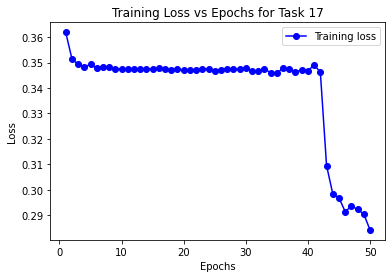

In [10]:
import matplotlib.pyplot as plt



# Plotting the loss vs epochs
epochs = range(1, len(losses1) + 1)
plt.plot(epochs, losses1, 'bo-', label='Training loss')
plt.title('Training Loss vs Epochs for Task 17')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
